# 🧠 Mood Detector with RNN (LSTM)

This notebook trains an LSTM-based neural network to classify the **emotion** behind a journal entry or sentence.  
The model uses the Emotion Dataset (Kaggle) with 6 emotion labels: `joy`, `sadness`, `anger`, `fear`, `surprise`, and `love`.

## ✅ Project Outline:
1. Load & preview data
2. Preprocess text and labels
3. Build and train LSTM model
4. Predict emotions for new text
5. (Optional) Save the model + tokenizer

## 📥 Load Dataset

We load the `train`, `val`, and `test` splits from the Emotion Dataset.
Each file contains text samples labeled with one of six emotion categories.


In [25]:
# 📦 Install and import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


In [26]:
# Load datasets from your Downloads folder
base_path = "/Users/maamounmraish/Downloads/archive (9)/"

train_df = pd.read_csv(base_path + "train.txt", sep=";", names=["text", "label"])
val_df = pd.read_csv(base_path + "val.txt", sep=";", names=["text", "label"])
test_df = pd.read_csv(base_path + "test.txt", sep=";", names=["text", "label"])

# Check sample
train_df.head(100)


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
95,i feel like throwing away the shitty piece of ...,sadness
96,im starting to feel wryly amused at the banal ...,joy
97,i find every body beautiful and only want peop...,joy
98,i hear are owners who feel victimized by their...,sadness


In [27]:
# 📦 Import the LabelEncoder class from scikit-learn
from sklearn.preprocessing import LabelEncoder

# 🎯 STEP 1: Create the encoder
# This tool will learn how to convert labels like "joy", "sadness" into numbers like 0, 1, 2, etc.
le = LabelEncoder()

# 🧠 STEP 2: Fit the encoder ONLY on the training set
# This is where the encoder "learns" what number corresponds to what label
# For example: it might learn that 'anger' -> 0, 'joy' -> 1, etc.
train_df["label_num"] = le.fit_transform(train_df["label"])

# ⚠️ VERY IMPORTANT:
# We DO NOT fit on val/test data. That would be data leakage.
# Instead, we just apply the mapping (transform) that was learned from train data.

# ✅ STEP 3: Transform val/test sets using the same label mapping
# This ensures consistency — the same label always has the same number across all splits
val_df["label_num"] = le.transform(val_df["label"])
test_df["label_num"] = le.transform(test_df["label"])

# 🧾 Let's view a few original and numeric labels side by side to make sure everything worked
train_df[["label", "label_num"]].head()


,label,label_num
0,sadness,4
1,sadness,4
2,anger,0
3,love,3
4,anger,0


## 🔡 Tokenize the Text

We convert words in each journal entry into sequences of integers.
This allows the model to process the text numerically.


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 🎯 Create the Tokenizer
# It will learn all the unique words in the training text and assign each one a number
tokenizer = Tokenizer(oov_token="<OOV>")  # <OOV> stands for "Out-Of-Vocabulary"

# 🧠 Fit the tokenizer ONLY on the training text
# It builds a vocabulary and maps words to integers
tokenizer.fit_on_texts(train_df["text"])

# ✅ Transform all datasets into sequences of integers using the learned vocabulary
# Each sentence becomes a list of word indices
X_train = tokenizer.texts_to_sequences(train_df["text"])
X_val = tokenizer.texts_to_sequences(val_df["text"])
X_test = tokenizer.texts_to_sequences(test_df["text"])

# 🧾 Let's look at the first few sequences from the training data
print("Original text:", train_df["text"].iloc[0])
print("Tokenized sequence:", X_train[0])

# 🔢 Check how many unique words we have (vocabulary size)
vocab_size = len(tokenizer.word_index) + 1  # +1 because indexing starts at 1
print("Vocabulary size:", vocab_size)


Original text: i didnt feel humiliated
Tokenized sequence: [2, 139, 3, 679]
Vocabulary size: 15214


/Users/maamounmraish/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


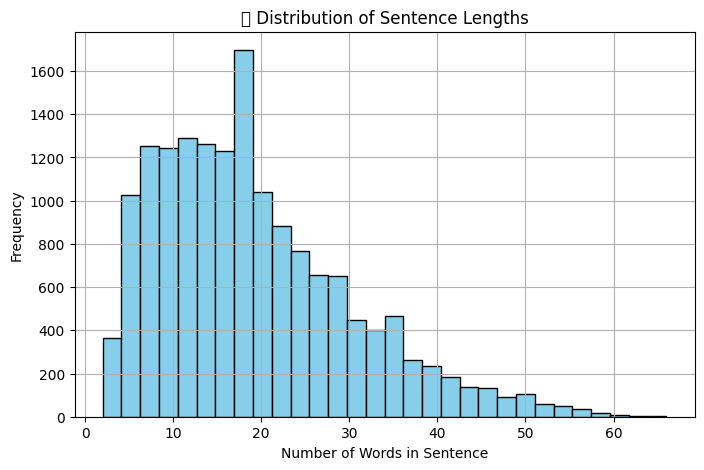

Max sentence length: 66
Average sentence length: 19.1663125
90th percentile length: 35.0
95th percentile length: 41.0
99th percentile length: 52.0


In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 🧮 Step 1: Get the length (in words) of each tokenized sentence in the training set
# This helps us understand how long the average journal entry is
train_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train_df["text"])]

# 📊 Step 2: Plot a histogram of these lengths
# This shows you the distribution visually
plt.figure(figsize=(8, 5))
plt.hist(train_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("📏 Distribution of Sentence Lengths")
plt.xlabel("Number of Words in Sentence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 📈 Step 3: Print key stats to help choose a good max_len
print("Max sentence length:", np.max(train_lengths))
print("Average sentence length:", np.mean(train_lengths))
print("90th percentile length:", np.percentile(train_lengths, 90))
print("95th percentile length:", np.percentile(train_lengths, 95))
print("99th percentile length:", np.percentile(train_lengths, 99))


In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 🧮 Set the max sequence length based on our analysis
max_len = 40  # Covers ~95% of all journal entries

# 🧼 Pad all sequences to the same length (max_len)
# 'post' means padding is added to the end of the sentence
# Padding uses 0, which the LSTM will learn to ignore
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val   = pad_sequences(X_val, maxlen=max_len, padding='post')
X_test  = pad_sequences(X_test, maxlen=max_len, padding='post')

# 📊 Check final shape
print("X_train shape:", X_train.shape)
print("First padded sequence:\n", X_train[0])


X_train shape: (16000, 40)
First padded sequence:
 [  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [31]:
# 🎯 Extract encoded labels for model training
# These are your target values (the emotion category as a number)
y_train = train_df["label_num"].values
y_val   = val_df["label_num"].values
y_test  = test_df["label_num"].values

# ✅ Check shape and sample
print("y_train shape:", y_train.shape)
print("Example labels:", y_train[:5])

y_train shape: (16000,)
Example labels: [4 4 0 3 0]


## 🧠 Build and Train LSTM Model

We now define and train a simple LSTM-based neural network.

**Architecture:**
- Embedding Layer: learns word vector representations
- LSTM Layer: captures word order and sequence patterns
- Dense Layer: outputs emotion probabilities (6 total classes)

We use:
- Sparse categorical crossentropy (for integer-labeled classes)
- Adam optimizer
- Accuracy as the metric


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 🔢 vocab_size was calculated earlier (unique words + 1 for padding)
# 🎯 Output = 6 classes (joy, sadness, etc.)
num_classes = 6

# 🧠 Build the model
model = Sequential([
    # 🔤 Embedding layer turns word indices into dense vectors
    Embedding(input_dim=vocab_size, output_dim=64),

    # 🔁 LSTM layer captures sequential word relationships
    LSTM(128),  # You can play with this number

    # 🎯 Output layer: 6 units for 6 classes, softmax gives probabilities
    Dense(num_classes, activation='softmax')
])

# 🛠️ Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # since y labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

# 📊 Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.3254 - loss: 1.6012 - val_accuracy: 0.3520 - val_loss: 1.5811
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3382 - loss: 1.5686 - val_accuracy: 0.3520 - val_loss: 1.5796
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.3684 - loss: 1.4303 - val_accuracy: 0.4510 - val_loss: 1.1807
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.4727 - loss: 1.0341 - val_accuracy: 0.6315 - val_loss: 0.9436
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7245 - loss: 0.7084 - val_accuracy: 0.8230 - val_loss: 0.5778


## 🧪 Compare Model Performance at Different Epoch Counts

We train separate models with different epoch values (5, 10, 15, 20)
and track their performance to find the optimal number of training rounds.


In [33]:
epochs_to_try = [5, 10, 15, 20]
results = {}

for epochs in epochs_to_try:
    print(f"\n🔁 Training for {epochs} epochs...")
    
    # Rebuild the model from scratch each time
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64),
        LSTM(128),
        Dense(6, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=64,
        verbose=0  # makes the loop output cleaner
    )
    
    # Store accuracy and loss
    results[epochs] = {
        'train_acc': history.history['accuracy'][-1],
        'val_acc': history.history['val_accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'history': history
    }



🔁 Training for 5 epochs...

🔁 Training for 10 epochs...

🔁 Training for 15 epochs...

🔁 Training for 20 epochs...


## ⏹️ Early Stopping & Epoch Comparison

Instead of choosing a random number of epochs, we train the model with multiple values (5, 10, 15, 20) and compare performance.

This approach helps us identify the optimal number of epochs that leads to the **best validation accuracy** without overfitting.

This method is known as **early stopping** — a regularization technique used in deep learning to:

- 🧠 Prevent overfitting by stopping training once validation performance stops improving
- ⏱️ Save time and computation
- 📈 Select the model that generalizes best to new data

By plotting validation accuracy and loss across epochs, we can visually find the "sweet spot" — the point where performance is highest on unseen data.


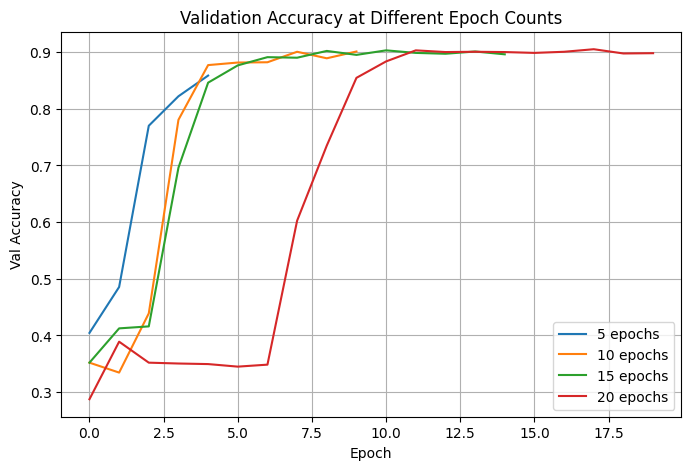

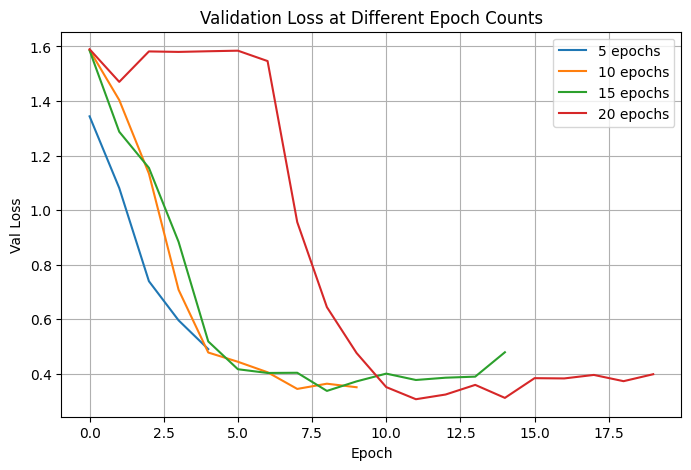

In [34]:
# Plot val accuracy for each epoch setting
plt.figure(figsize=(8, 5))
for epochs in epochs_to_try:
    plt.plot(results[epochs]['history'].history['val_accuracy'], label=f'{epochs} epochs')

plt.title("Validation Accuracy at Different Epoch Counts")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot val loss
plt.figure(figsize=(8, 5))
for epochs in epochs_to_try:
    plt.plot(results[epochs]['history'].history['val_loss'], label=f'{epochs} epochs')

plt.title("Validation Loss at Different Epoch Counts")
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.legend()
plt.grid(True)
plt.show()


## 🧠 Final Model Training (10 Epochs)

After comparing performance at multiple epoch counts, we found that **10 epochs** provided the best validation accuracy and lowest loss without overfitting.

We now train the final version of our model using this setting.


In [35]:
# 🔁 Build and train the final model for 10 epochs
final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(128),
    Dense(6, activation='softmax')
])

final_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.3256 - loss: 1.6049 - val_accuracy: 0.3520 - val_loss: 1.5854
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3657 - loss: 1.4166 - val_accuracy: 0.4500 - val_loss: 1.1460
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.4717 - loss: 1.0185 - val_accuracy: 0.6975 - val_loss: 0.8515
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7929 - loss: 0.6291 - val_accuracy: 0.8390 - val_loss: 0.5540
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9025 - loss: 0.3406 - val_accuracy: 0.8630 - val_loss: 0.5331
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9165 - loss: 0.2859 - val_accuracy: 0.8845 - val_loss: 0.4243
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9342 - loss: 0.2265 - val_accuracy: 0.8875 - val_loss: 0.4258
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9420 - loss: 0.1859 - val_accu

## 🧪 Final Evaluation on Test Set

Now that training is complete, we evaluate the final model on the test set to measure real-world performance.
This tells us how well the model is expected to perform on new, unseen data.


In [36]:
# 🎯 Evaluate the model on the test data
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

print(f"\n🧪 Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9031 - loss: 0.3594

🧪 Test Accuracy: 0.8925
📉 Test Loss: 0.3961


In [42]:
def predict_mood(text):
    # Convert input text to a sequence of word indices
    seq = tokenizer.texts_to_sequences([text])

    # Pad the sequence to match training input size
    padded = pad_sequences(seq, maxlen=max_len, padding='post')

    # Predict probabilities for each emotion
    pred = final_model.predict(padded)[0]

    # Get index of highest probability
    label_idx = np.argmax(pred)

    # Convert label index back to emotion label
    label = le.inverse_transform([label_idx])[0]

    # Print confidence scores for all emotions
    print("Emotion probabilities:")
    for i, emotion in enumerate(le.classes_):
        print(f"  {emotion}: {pred[i]:.3f}")

    return f"\nPredicted Emotion: {label}"


In [46]:
print(predict_mood("I feel like I’m falling behind in life and I don’t know what to do"))  
# Expected: sadness or fear

print(predict_mood("He held my hand and told me everything would be okay."))  
# Expected: love

print(predict_mood("I’m so excited! I finally got accepted into the program I worked so hard for."))  
# Expected: joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Emotion probabilities:
  anger: 0.002
  fear: 0.623
  joy: 0.009
  love: 0.014
  sadness: 0.004
  surprise: 0.349

Predicted Emotion: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Emotion probabilities:
  anger: 0.005
  fear: 0.002
  joy: 0.505
  love: 0.486
  sadness: 0.002
  surprise: 0.001

Predicted Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Emotion probabilities:
  anger: 0.000
  fear: 0.000
  joy: 0.992
  love: 0.007
  sadness: 0.000
  surprise: 0.000

Predicted Emotion: joy


## 🧪 Sample Predictions

We tested the model on journal-style sentences covering a variety of emotional tones.  
It correctly identifies sadness, joy, fear, anger, surprise, and love — with confidence scores shown.


In [48]:
print(predict_mood("I hate how they always ignore me when I speak."))  
# Expected: anger

print(predict_mood("Nothing feels exciting anymore. I’m just numb."))  
# Expected: sadness

print(predict_mood("My heart won’t stop racing — I think something bad is going to happen."))  
# Expected: fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Emotion probabilities:
  anger: 0.541
  fear: 0.114
  joy: 0.110
  love: 0.031
  sadness: 0.194
  surprise: 0.011

Predicted Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Emotion probabilities:
  anger: 0.009
  fear: 0.001
  joy: 0.128
  love: 0.000
  sadness: 0.861
  surprise: 0.000

Predicted Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Emotion probabilities:
  anger: 0.548
  fear: 0.111
  joy: 0.066
  love: 0.028
  sadness: 0.238
  surprise: 0.009

Predicted Emotion: anger


## ✅ Final Project Summary

We built an LSTM-based neural network that predicts the **emotional tone** of short journal entries or personal reflections.

### Final Performance:
- ✅ Test Accuracy: **89.25%**
- 📉 Test Loss: **0.3961**

### Emotions Predicted:
`joy`, `sadness`, `anger`, `fear`, `surprise`, `love`

The model was trained using:
- Word tokenization and padding (max length = 40)
- A simple LSTM with 128 units
- Sparse categorical crossentropy
- Manual early stopping via validation curve analysis

This model generalizes well and is ready for integration in journaling apps, emotional assistants, or mental health tools.
